# 今回の取り組み

- `correct_sequence_error`があるとメモリや速度的に問題が生じるので、これを除いたフローチャートを考えます💡

- `correct_sequence_error`が必要そうな箇所はどこか
    - ⬜ `classification`
    - ✅ `clustering`
    - ✅ `consensus call`

## いつものセットアップ

In [1]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if Path(os.getcwd()).stem != "DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)

print(os.getcwd())
sys.path.append(os.getcwd() + "/" + "src")

/mnt/d/Research/DAJIN2


In [2]:
%%bash
pip uninstall -qy DAJIN2
# pip install -q -e .
# pipの更新
# pip install -q -U pip
# pip install -q -U -r requirements.txt

# 実験

In [3]:
from __future__ import annotations
from pathlib import Path

from src.DAJIN2.core import preprocess, classification, clustering, consensus, report

#### # * Subset of Point mutation
#### # 50 or 10 or 01%
percent = "50"
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    "misc/data/r10_barcode31.fq.gz",
    "misc/data/r10_barcode32.fq.gz",
    "misc/data/tyr_control.fasta",
    "single-r10",
    "mm10",
    True,
    30,
)


######################################################################
# Preprocessing
######################################################################

print(f"processing {NAME}...")

# ====================================================================
# Varidate inputs
# ====================================================================

preprocess.validate_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.validate_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.validate_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.validate_inputs.check_and_fetch_genome(GENOME)

# ====================================================================
# Format inputs
# ====================================================================
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
THREADS = preprocess.format_inputs.update_threads(THREADS)

SUBDIRS = ["cache", "fasta", "sam", "midsv", "midsv_corrected", "report", "result", "mutation_loci"]
preprocess.format_inputs.make_directories(TEMPDIR, SUBDIRS, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)


processing single-r10...


In [4]:
MUTATION_LOCI_ALLELES = preprocess.extract_mutation_loci(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME, CONTROL_NAME)

In [21]:
print(MUTATION_LOCI_ALLELES.keys())
print(MUTATION_LOCI_ALLELES["control"][828])

dict_keys(['control'])
{'*', '-'}


- `classification`には補正は必要ないのでそのまま実行

In [10]:
from __future__ import annotations

from collections import defaultdict
from itertools import groupby, permutations
from pathlib import Path

import midsv
import json
from typing import Generator
from DAJIN2.core.preprocess import mappy_align


def _extract_diff_loci(TEMPDIR: Path) -> defaultdict[dict]:
    """
    Extract differencial loci between alleles
        - The purpose is to lower match_score between very similar alleles such as point mutation.
    """
    fasta_alleles = list(Path(TEMPDIR, "fasta").iterdir())
    fasta_alleles = [f for f in fasta_alleles if f.suffix != ".fai"]
    mutation_alleles = defaultdict(dict)
    for pair in list(permutations(fasta_alleles, 2)):
        ref, query = pair
        ref_allele = ref.stem
        alignments = mappy_align.to_sam(ref, query, preset="splice")
        alignments = list(alignments)
        alignments = [a.split("\t") for a in alignments]
        alignments_midsv = midsv.transform(alignments, midsv=False, cssplit=True, qscore=False)[0]
        cssplits = alignments_midsv["CSSPLIT"].split(",")
        mutations = dict()
        for i, cs in enumerate(cssplits):
            if cs.startswith("="):
                continue
            mutations.update({i: cs})
        if len(mutations) < 10:
            mutation_alleles[ref_allele].update(mutations)
    return mutation_alleles


def _calc_match(CSSPLIT: str, mutations: dict) -> float:
    match_score = CSSPLIT.count("=")
    match_score -= CSSPLIT.count("+")  # insertion
    match_score -= sum(cs.islower() for cs in CSSPLIT)  # inversion
    cssplit = CSSPLIT.split(",")
    for i, mut in mutations.items():
        if cssplit[i] == mut:
            match_score = 0
    return match_score / len(cssplit)


def read_json(filepath) -> Generator[dict[str, str]]:
    with open(filepath, "r") as f:
        for line in f:
            yield json.loads(line)


###########################################################
# main
###########################################################


def classify_alleles(TEMPDIR: Path, FASTA_ALLELES: dict, SAMPLE_NAME: str) -> list[dict]:
    mutations = _extract_diff_loci(TEMPDIR)
    # Scoring
    score_of_each_alleles = []
    for allele in FASTA_ALLELES:
        midsv_sample = read_json(Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.json"))
        for dict_midsv in midsv_sample:
            score = _calc_match(dict_midsv["CSSPLIT"], mutations[allele])
            dict_midsv.update({"SCORE": score})
            dict_midsv.update({"ALLELE": allele})
            score_of_each_alleles.append(dict_midsv)
    score_of_each_alleles.sort(key=lambda x: x["QNAME"])
    # Extract alleles with max scores
    possible_allele = []
    for _, group in groupby(score_of_each_alleles, key=lambda x: x["QNAME"]):
        max_score = -float("inf")
        for readinfo in group:
            if readinfo["SCORE"] > max_score:
                max_score = readinfo["SCORE"]
                max_read = readinfo
                del max_read["SCORE"]
        possible_allele.append(max_read)
    return possible_allele


In [11]:
x = classify_alleles(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)

In [13]:
print(len(x))
print(x[0])

24453
{'QNAME': '0006507f-0c02-4a2e-bfac-54019beea950', 'CSSPLIT': '=T,=G,=C,=A,=T,*TC,=G,=A,=A,=G,=C,=A,=G,=T,=T,=C,=A,=C,=C,=A,=A,=A,=A,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=C,=A,=A,=A,=G,*TA,=A,=A,+C|*GA,=A,*TG,=A,=T,=C,=T,=T,=T,=G,=G,=A,=A,=T,=A,=A,=T,=C,=A,=A,=T,=T,=C,=A,=A,=G,=A,=T,=A,=A,=T,=C,=A,=A,=G,=G,=A,=A,=A,=A,=A,=T,=G,=A,=G,=A,=G,=G,=C,=A,*AG,=C,=T,=A,=T,=T,=T,=T,=A,=G,=A,=C,=T,=G,=A,=T,=T,=A,=C,=T,=T,=T,=T,=A,=T,-A,=A,=A,=A,=T,=A,=A,=A,=T,=A,=A,=G,=C,=T,=C,+A|+A|=A,=G,=C,-T,=T,=A,=G,=C,=C,=A,=G,=A,=T,=A,=T,=A,=A,=G,=C,=A,=A,=T,=A,=T,=T,=C,=T,=G,=A,=G,=T,=T,=C,=T,=G,=A,=A,=G,=A,=A,=A,=A,=A,=T,=T,=T,=T,=T,=G,=A,=C,=A,=A,=A,=A,=T,=G,=A,=G,=T,=T,=C,+G|=T,=A,=T,=A,=A,=A,=T,=G,=T,=T,=A,=T,-T,-G,-T,-C,=T,=A,=C,=T,=T,=A,=T,=G,=A,=T,=C,=T,=C,=T,=A,=A,=A,=T,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=T,=G,=T,=A,=T,=T,=C,=A,=G,+C|=A,=A,=T,=C,=T,=A,=G,=A,=T,=G,=T,=T,=T,=C,=A,=T,=G,=A,=C,=C,=T,=T,=T,=A,=T,=T,=C,=A,=T,=A,=A,=G,=A,=G,=A,=T,=G,=A,=T,=G,=T,=A,=T,=T,=C,=T,=T,=G,=A,=T,=A,=C,=T,=A,=C,=T,=T,

In [16]:
def classify_alleles(TEMPDIR: Path, FASTA_ALLELES: dict, SAMPLE_NAME: str) -> list[dict]:
    mutations = _extract_diff_loci(TEMPDIR)
    # Scoring
    score_of_each_alleles = []
    for allele in FASTA_ALLELES:
        midsv_sample = read_json(Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.json"))
        for dict_midsv in midsv_sample:
            score = _calc_match(dict_midsv["CSSPLIT"], mutations[allele])
            dict_midsv.update({"SCORE": score})
            dict_midsv.update({"ALLELE": allele})
            score_of_each_alleles.append(dict_midsv)
    score_of_each_alleles.sort(key=lambda x: x["QNAME"])
    # Extract alleles with max scores
    for _, group in groupby(score_of_each_alleles, key=lambda x: x["QNAME"]):
        max_score = -float("inf")
        for readinfo in group:
            if readinfo["SCORE"] > max_score:
                max_score = readinfo["SCORE"]
                max_read = readinfo
                del max_read["SCORE"]
        yield max_read

In [17]:
x = classify_alleles(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)
print(next(x))

{'QNAME': '0006507f-0c02-4a2e-bfac-54019beea950', 'CSSPLIT': '=T,=G,=C,=A,=T,*TC,=G,=A,=A,=G,=C,=A,=G,=T,=T,=C,=A,=C,=C,=A,=A,=A,=A,=T,=A,=A,=C,=A,=A,=A,=G,=T,=A,=A,=C,=A,=A,=A,=G,*TA,=A,=A,+C|*GA,=A,*TG,=A,=T,=C,=T,=T,=T,=G,=G,=A,=A,=T,=A,=A,=T,=C,=A,=A,=T,=T,=C,=A,=A,=G,=A,=T,=A,=A,=T,=C,=A,=A,=G,=G,=A,=A,=A,=A,=A,=T,=G,=A,=G,=A,=G,=G,=C,=A,*AG,=C,=T,=A,=T,=T,=T,=T,=A,=G,=A,=C,=T,=G,=A,=T,=T,=A,=C,=T,=T,=T,=T,=A,=T,-A,=A,=A,=A,=T,=A,=A,=A,=T,=A,=A,=G,=C,=T,=C,+A|+A|=A,=G,=C,-T,=T,=A,=G,=C,=C,=A,=G,=A,=T,=A,=T,=A,=A,=G,=C,=A,=A,=T,=A,=T,=T,=C,=T,=G,=A,=G,=T,=T,=C,=T,=G,=A,=A,=G,=A,=A,=A,=A,=A,=T,=T,=T,=T,=T,=G,=A,=C,=A,=A,=A,=A,=T,=G,=A,=G,=T,=T,=C,+G|=T,=A,=T,=A,=A,=A,=T,=G,=T,=T,=A,=T,-T,-G,-T,-C,=T,=A,=C,=T,=T,=A,=T,=G,=A,=T,=C,=T,=C,=T,=A,=A,=A,=T,=A,=C,=A,=A,=C,=A,=G,=G,=C,=T,=T,=G,=T,=A,=T,=T,=C,=A,=G,+C|=A,=A,=T,=C,=T,=A,=G,=A,=T,=G,=T,=T,=T,=C,=A,=T,=G,=A,=C,=C,=T,=T,=T,=A,=T,=T,=C,=A,=T,=A,=A,=G,=A,=G,=A,=T,=G,=A,=T,=G,=T,=A,=T,=T,=C,=T,=T,=G,=A,=T,=A,=C,=T,=A,=C,=T,=T,=C,=T,

- 試しに、DAJIN2のsingle modeを実行してみます

In [26]:
%%bash
# rm -rf DAJINResults/single_r10
# rm -rf DAJINResults/.tempdir/single_r10

pip install -q -e .

time DAJIN2 \
    --name single_r10 \
    --sample     "misc/data/r10_barcode31.fq.gz" \
    --control    "misc/data/r10_barcode32.fq.gz" \
    --allele     "misc/data/tyr_control.fasta" \
    --genome mm10 \
    --threads 10

misc/data/r10_barcode32.fq.gz is now processing...
misc/data/r10_barcode32.fq.gz is already preprocessed and reuse the results for the current run...
misc/data/r10_barcode31.fq.gz is now processing...
2023-05-16 17:26:18: Preprocess r10_barcode31...
2023-05-16 17:26:18: Mapping r10_barcode31...
2023-05-16 17:27:07: Call MIDSV r10_barcode31...
2023-05-16 17:27:33: extract_mutation_loci r10_barcode31...
2023-05-16 17:28:13: Classify r10_barcode31...
2023-05-16 17:28:24: Clustering r10_barcode31...


Traceback (most recent call last):
  File "/home/kuno/miniconda/bin/DAJIN2", line 33, in <module>
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/DAJIN2.py", line 276, in main
    _execute_single_mode(arguments)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/DAJIN2.py", line 42, in _execute_single_mode
    core_execute.execute_sample(arguments)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/core_execute.py", line 164, in execute_sample
    clust_sample = clustering.add_labels(
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/clustering/clustering.py", line 107, in add_labels
    labels = return_labels(scores_sample, scores_control)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/clustering/return_labels.py", line 56, in return_labels
    X_control = reduce_dimension([], scores_control)
  File "/mnt/d/Research/DAJIN2/src/DAJIN2/core/clustering/return_labels.py", line 23, in reduce_dimension
    scores = scores_sample + scores_control_subset
TypeError: can only concatenate list (not "generator") to li

CalledProcessError: Command 'b'# rm -rf DAJINResults/single_r10\n# rm -rf DAJINResults/.tempdir/single_r10\n\npip install -q -e .\n\ntime DAJIN2 \\\n    --name single_r10 \\\n    --sample     "misc/data/r10_barcode31.fq.gz" \\\n    --control    "misc/data/r10_barcode32.fq.gz" \\\n    --allele     "misc/data/tyr_control.fasta" \\\n    --genome mm10 \\\n    --threads 10\n'' returned non-zero exit status 1.

- Clusteringでエラーが出るので対応します

In [29]:
def classify_alleles(TEMPDIR: Path, FASTA_ALLELES: dict, SAMPLE_NAME: str) -> list[dict]:
    mutations = _extract_diff_loci(TEMPDIR)
    # Scoring
    score_of_each_alleles = []
    for allele in FASTA_ALLELES:
        midsv_sample = read_json(Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.json"))
        for dict_midsv in midsv_sample:
            score = _calc_match(dict_midsv["CSSPLIT"], mutations[allele])
            dict_midsv.update({"SCORE": score})
            dict_midsv.update({"ALLELE": allele})
            score_of_each_alleles.append(dict_midsv)
    score_of_each_alleles.sort(key=lambda x: x["QNAME"])
    # Extract alleles with max scores
    possible_allele = []
    for _, group in groupby(score_of_each_alleles, key=lambda x: x["QNAME"]):
        max_score = -float("inf")
        for readinfo in group:
            if readinfo["SCORE"] > max_score:
                max_score = readinfo["SCORE"]
                max_read = readinfo
                del max_read["SCORE"]
        possible_allele.append(max_read)
    return possible_allele

classif_sample = classify_alleles(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)

In [30]:
classif_sample.sort(key=lambda x: x["ALLELE"])

In [31]:
from __future__ import annotations

from collections import defaultdict
from itertools import groupby
from typing import Generator
import json
from pathlib import Path
from DAJIN2.core.clustering.make_score import make_score
from DAJIN2.core.clustering.return_labels import return_labels


def _compress_insertion(cssplits: Generator[list[str]]) -> Generator[dict[str, int]]:
    """Insertion will be subdivided by sequence error in the its sequence,
    so it is compressed as a '+I' to eliminate mutations.
    #TODO ただ、これでは、insertion配列の中に真のmutationがある場合に
    #TODO そのmutationを抽出できないので**insertion配列の中にmutationがある場合は
    #TODO insertion配列をそのまま残す**必要がある。
    """
    for cssplit in cssplits:
        for i, cs in enumerate(cssplit):
            if cs.startswith("+"):
                cssplit[i] = "+I" + cs.split("|")[-1]
        yield cssplit


def _extract_cssplits_in_mutation_by_3mer(
    cssplits: Generator[list[str]], mutation_loci: list[set[str]]
) -> Generator[list[str]]:
    for cssplit in cssplits:
        cs_mutation = ["N,N,N"]
        for i in range(1, len(cssplit) - 1):
            if mutation_loci[i] == set():
                cs_mutation.append("N,N,N")
                continue
            mutation = ""
            if cssplit[i].startswith("+"):
                mutation = "ins"
            elif cssplit[i].startswith("-"):
                mutation = "del"
            elif cssplit[i].startswith("*"):
                mutation = "sub"
            if mutation in mutation_loci[i]:
                kmer = ",".join([cssplit[i - 1], cssplit[i], cssplit[i + 1]])
                cs_mutation.append(kmer)
            else:
                cs_mutation.append("N,N,N")
        cs_mutation.append("N,N,N")
        yield cs_mutation


def _annotate_score(cssplits: Generator[list[str]], mutation_score: list[dict[str:float]]) -> Generator[list[float]]:
    for cssplit in cssplits:
        score = [0 for _ in range(len(cssplit))]
        for i, (cs, mutscore) in enumerate(zip(cssplit, mutation_score)):
            if mutscore == {}:
                continue
            if cs in mutscore:
                score[i] = mutscore[cs]
        yield score


def _reorder_labels(labels: list[int], start: int = 0) -> list[int]:
    labels_ordered = labels.copy()
    num = start
    d = defaultdict(int)
    for i, l in enumerate(labels_ordered):
        if not d[l]:
            num += 1
            d[l] = num
        labels_ordered[i] = d[l]
    return labels_ordered


def read_json(filepath) -> Generator[dict[str, str]]:
    with open(filepath, "r") as f:
        for line in f:
            yield json.loads(line)


def add_labels(
    classif_sample, TEMPDIR, CONTROL_NAME, MUTATION_LOCI_ALLELES, KNOCKIN_LOCI_ALLELES, THREADS: int = 1
) -> list[dict[str]]:
    labels_all = []
    max_label = 0
    classif_sample.sort(key=lambda x: x["ALLELE"])
    for allele, group in groupby(classif_sample, key=lambda x: x["ALLELE"]):
        mutation_loci: dict[str, set[str]] = MUTATION_LOCI_ALLELES[allele]
        if all(m == set() for m in mutation_loci):
            labels = [1] * len(classif_sample)
            labels_reorder = _reorder_labels(labels, start=max_label)
            max_label = max(labels_reorder)
            labels_all.extend(labels_reorder)
            continue
        knockin_loci = set()
        if allele in KNOCKIN_LOCI_ALLELES:
            knockin_loci = KNOCKIN_LOCI_ALLELES[allele]
        midsv_control = read_json(Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.json"))
        cssplits_sample = _compress_insertion((cs["CSSPLIT"].split(",") for cs in group))
        cssplits_control = _compress_insertion((cs["CSSPLIT"].split(",") for cs in midsv_control))
        cssplits_mutation_loci_sample = _extract_cssplits_in_mutation_by_3mer(cssplits_sample, mutation_loci)
        cssplits_mutation_loci_control = _extract_cssplits_in_mutation_by_3mer(cssplits_control, mutation_loci)
        mutation_score = make_score(
            cssplits_mutation_loci_sample, cssplits_mutation_loci_control, mutation_loci, knockin_loci
        )
        scores_sample = _annotate_score(cssplits_mutation_loci_sample, mutation_score)
        scores_control = _annotate_score(cssplits_mutation_loci_control, mutation_score)
        labels = return_labels(scores_sample, scores_control)
        labels_reorder = _reorder_labels(labels, start=max_label)
        max_label = max(labels_reorder)
        labels_all.extend(labels_reorder)
    clust_sample = classif_sample.copy()
    for clust, label in zip(clust_sample, labels_all):
        clust["LABEL"] = label
    return clust_sample


In [37]:
allele = "control"
KNOCKIN_LOCI_ALLELES = preprocess.extract_knockin_loci(TEMPDIR)
group = [cs for cs in classif_sample if cs["ALLELE"] == allele]

In [41]:
from __future__ import annotations

from collections import Counter
from typing import Generator


def _call_count(cssplits_sample: Generator[list[str]], mutation_loci) -> list[dict[str, int]]:
    count_kmer = []
    for i, cssplits_transposed in enumerate(zip(*cssplits_sample)):
        count_kmer.append(dict(Counter(cssplits_transposed)))
    return count_kmer


def _call_percent(counts: list[dict[str, int]]) -> list[dict[str, float]]:
    cssplit_percent = []
    coverage = sum(counts[0].values())
    for count in counts:
        percent = {k: v / coverage * 100 for k, v in count.items()}
        cssplit_percent.append(percent)
    return cssplit_percent


def _subtract_percentage(percent_control, percent_sample, knockin_loci: set(int)) -> list[dict]:
    sample_subtracted = []
    for i, (cont, samp) in enumerate(zip(percent_control, percent_sample)):
        if i in knockin_loci:
            sample_subtracted.append(dict(samp))
            continue
        samp = Counter(samp)
        samp.subtract(Counter(cont))
        sample_subtracted.append(dict(samp))
    return sample_subtracted


def _discard_common_error(percent_subtraction, threshold=0.5) -> list[dict]:
    percent_discarded = []
    for samp in percent_subtraction:
        remained = {k: v for k, v in samp.items() if v > threshold}
        percent_discarded.append(remained)
    return percent_discarded


def _discard_match_and_n(percent_discarded) -> list[dict]:
    mutation_score_discarded = [dict() for _ in range(len(percent_discarded))]
    for i, mutation_percent in enumerate(percent_discarded):
        if mutation_percent == {} or "" in mutation_percent:
            continue
        for mutation, percent in mutation_percent.items():
            mutation_center = mutation.split(",")[1]
            if mutation_center.startswith("=") or mutation_center == ("N"):
                continue
            mutation_score_discarded[i].update({mutation: percent})
    return mutation_score_discarded


###############################################################################
# main
###############################################################################


def make_score(
    cssplits_sample, cssplits_control, mutation_loci: dict[str, set[int]], knockin_loci: set(int)
) -> list[dict[str, float]]:
    counts_sample = _call_count(cssplits_sample, mutation_loci)
    counts_control = _call_count(cssplits_control, mutation_loci)
    percent_sample = _call_percent(counts_sample)
    percent_control = _call_percent(counts_control)
    percent_subtraction = _subtract_percentage(percent_control, percent_sample, knockin_loci)
    percent_discarded = _discard_common_error(percent_subtraction, 0.5)
    mutation_score = _discard_match_and_n(percent_discarded)
    return mutation_score


In [42]:

mutation_loci: dict[str, set[str]] = MUTATION_LOCI_ALLELES[allele]
knockin_loci = set()
if allele in KNOCKIN_LOCI_ALLELES:
    knockin_loci = KNOCKIN_LOCI_ALLELES[allele]
midsv_control = read_json(Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.json"))
cssplits_sample = _compress_insertion((cs["CSSPLIT"].split(",") for cs in group))
cssplits_control = _compress_insertion((cs["CSSPLIT"].split(",") for cs in midsv_control))
cssplits_mutation_loci_sample = _extract_cssplits_in_mutation_by_3mer(cssplits_sample, mutation_loci)
cssplits_mutation_loci_control = _extract_cssplits_in_mutation_by_3mer(cssplits_control, mutation_loci)
mutation_score = make_score(
    cssplits_mutation_loci_sample, cssplits_mutation_loci_control, mutation_loci, knockin_loci
)
scores_sample = _annotate_score(cssplits_mutation_loci_sample, mutation_score)
scores_control = _annotate_score(cssplits_mutation_loci_control, mutation_score)
labels = return_labels(scores_sample, scores_control)

TypeError: can only concatenate list (not "generator") to list

- 不用意にGeneratorにしたので、対応しきれていないようです

In [43]:
def _annotate_score(cssplits: Generator[list[str]], mutation_score: list[dict[str:float]]) -> list[list[float]]:
    scores = []
    for cssplit in cssplits:
        score = [0 for _ in range(len(cssplit))]
        for i, (cs, mutscore) in enumerate(zip(cssplit, mutation_score)):
            if mutscore == {}:
                continue
            if cs in mutscore:
                score[i] = mutscore[cs]
        scores.append(score)
    return scores



In [45]:
mutation_loci: dict[str, set[str]] = MUTATION_LOCI_ALLELES[allele]
knockin_loci = set()
if allele in KNOCKIN_LOCI_ALLELES:
    knockin_loci = KNOCKIN_LOCI_ALLELES[allele]
midsv_control = read_json(Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.json"))
cssplits_sample = _compress_insertion((cs["CSSPLIT"].split(",") for cs in group))
cssplits_control = _compress_insertion((cs["CSSPLIT"].split(",") for cs in midsv_control))
cssplits_mutation_loci_sample = _extract_cssplits_in_mutation_by_3mer(cssplits_sample, mutation_loci)
cssplits_mutation_loci_control = _extract_cssplits_in_mutation_by_3mer(cssplits_control, mutation_loci)
mutation_score = make_score(
    cssplits_mutation_loci_sample, cssplits_mutation_loci_control, mutation_loci, knockin_loci
)
scores_sample = _annotate_score(cssplits_mutation_loci_sample, mutation_score)
scores_control = _annotate_score(cssplits_mutation_loci_control, mutation_score)
labels = return_labels(scores_sample, scores_control)

IndexError: list index out of range

In [49]:
print(classif_sample.__sizeof__() / 1024 / 1024)

0.20890045166015625


In [52]:
print(sum(1 for m in MUTATION_LOCI_ALLELES[allele] if m != set()))

541


- 本当は大掛かりにコードを治す必要がありそうです

- いったんGeneratorをListに戻します

In [56]:
from __future__ import annotations

from collections import defaultdict
from itertools import groupby
from typing import Generator
import json
from pathlib import Path
from DAJIN2.core.clustering.make_score import make_score
from DAJIN2.core.clustering.return_labels import return_labels


def _compress_insertion(cssplits: Generator[list[str]]) -> Generator[dict[str, int]]:
    """Insertion will be subdivided by sequence error in the its sequence,
    so it is compressed as a '+I' to eliminate mutations.
    #TODO ただ、これでは、insertion配列の中に真のmutationがある場合に
    #TODO そのmutationを抽出できないので**insertion配列の中にmutationがある場合は
    #TODO insertion配列をそのまま残す**必要がある。
    """
    for cssplit in cssplits:
        for i, cs in enumerate(cssplit):
            if cs.startswith("+"):
                cssplit[i] = "+I" + cs.split("|")[-1]
        yield cssplit


def _extract_cssplits_in_mutation_by_3mer(
    cssplits: Generator[list[str]], mutation_loci: list[set[str]]
) -> list[list[str]]:
    cssplits_mutation = []
    for cssplit in cssplits:
        cs_mutation = ["N,N,N"]
        for i in range(1, len(cssplit) - 1):
            if mutation_loci[i] == set():
                cs_mutation.append("N,N,N")
                continue
            mutation = ""
            if cssplit[i].startswith("+"):
                mutation = "ins"
            elif cssplit[i].startswith("-"):
                mutation = "del"
            elif cssplit[i].startswith("*"):
                mutation = "sub"
            if mutation in mutation_loci[i]:
                kmer = ",".join([cssplit[i - 1], cssplit[i], cssplit[i + 1]])
                cs_mutation.append(kmer)
            else:
                cs_mutation.append("N,N,N")
        cs_mutation.append("N,N,N")
        cssplits_mutation.append(cs_mutation)
    return cssplits_mutation


def _annotate_score(cssplits: Generator[list[str]], mutation_score: list[dict[str:float]]) -> list[list[float]]:
    scores = []
    for cssplit in cssplits:
        score = [0 for _ in range(len(cssplit))]
        for i, (cs, mutscore) in enumerate(zip(cssplit, mutation_score)):
            if mutscore == {}:
                continue
            if cs in mutscore:
                score[i] = mutscore[cs]
        scores.append(score)
    return scores


def _reorder_labels(labels: list[int], start: int = 0) -> list[int]:
    labels_ordered = labels.copy()
    num = start
    d = defaultdict(int)
    for i, l in enumerate(labels_ordered):
        if not d[l]:
            num += 1
            d[l] = num
        labels_ordered[i] = d[l]
    return labels_ordered


def read_json(filepath) -> Generator[dict[str, str]]:
    with open(filepath, "r") as f:
        for line in f:
            yield json.loads(line)


def add_labels(
    classif_sample, TEMPDIR, CONTROL_NAME, MUTATION_LOCI_ALLELES, KNOCKIN_LOCI_ALLELES, THREADS: int = 1
) -> list[dict[str]]:
    labels_all = []
    max_label = 0
    classif_sample.sort(key=lambda x: x["ALLELE"])
    for allele, group in groupby(classif_sample, key=lambda x: x["ALLELE"]):
        mutation_loci: dict[str, set[str]] = MUTATION_LOCI_ALLELES[allele]
        if all(m == set() for m in mutation_loci):
            labels = [1] * len(classif_sample)
            labels_reorder = _reorder_labels(labels, start=max_label)
            max_label = max(labels_reorder)
            labels_all.extend(labels_reorder)
            continue
        knockin_loci = set()
        if allele in KNOCKIN_LOCI_ALLELES:
            knockin_loci = KNOCKIN_LOCI_ALLELES[allele]
        midsv_control = read_json(Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.json"))
        cssplits_sample = _compress_insertion((cs["CSSPLIT"].split(",") for cs in group))
        cssplits_control = _compress_insertion((cs["CSSPLIT"].split(",") for cs in midsv_control))
        cssplits_mutation_loci_sample = _extract_cssplits_in_mutation_by_3mer(cssplits_sample, mutation_loci)
        cssplits_mutation_loci_control = _extract_cssplits_in_mutation_by_3mer(cssplits_control, mutation_loci)
        mutation_score = make_score(
            cssplits_mutation_loci_sample, cssplits_mutation_loci_control, mutation_loci, knockin_loci
        )
        scores_sample = _annotate_score(cssplits_mutation_loci_sample, mutation_score)
        scores_control = _annotate_score(cssplits_mutation_loci_control, mutation_score)
        labels = return_labels(scores_sample, scores_control)
        labels_reorder = _reorder_labels(labels, start=max_label)
        max_label = max(labels_reorder)
        labels_all.extend(labels_reorder)
    clust_sample = classif_sample.copy()
    for clust, label in zip(clust_sample, labels_all):
        clust["LABEL"] = label
    return clust_sample

from __future__ import annotations

from collections import Counter
from typing import Generator


def _call_count(cssplits_sample: Generator[list[str]], mutation_loci) -> list[dict[str, int]]:
    count_kmer = []
    for i, cssplits_transposed in enumerate(zip(*cssplits_sample)):
        count_kmer.append(dict(Counter(cssplits_transposed)))
    return count_kmer


def _call_percent(counts: list[dict[str, int]]) -> list[dict[str, float]]:
    cssplit_percent = []
    coverage = sum(counts[0].values())
    for count in counts:
        percent = {k: v / coverage * 100 for k, v in count.items()}
        cssplit_percent.append(percent)
    return cssplit_percent


def _subtract_percentage(percent_control, percent_sample, knockin_loci: set(int)) -> list[dict]:
    sample_subtracted = []
    for i, (cont, samp) in enumerate(zip(percent_control, percent_sample)):
        if i in knockin_loci:
            sample_subtracted.append(dict(samp))
            continue
        samp = Counter(samp)
        samp.subtract(Counter(cont))
        sample_subtracted.append(dict(samp))
    return sample_subtracted


def _discard_common_error(percent_subtraction, threshold=0.5) -> list[dict]:
    percent_discarded = []
    for samp in percent_subtraction:
        remained = {k: v for k, v in samp.items() if v > threshold}
        percent_discarded.append(remained)
    return percent_discarded


def _discard_match_and_n(percent_discarded) -> list[dict]:
    mutation_score_discarded = [dict() for _ in range(len(percent_discarded))]
    for i, mutation_percent in enumerate(percent_discarded):
        if mutation_percent == {} or "" in mutation_percent:
            continue
        for mutation, percent in mutation_percent.items():
            mutation_center = mutation.split(",")[1]
            if mutation_center.startswith("=") or mutation_center == ("N"):
                continue
            mutation_score_discarded[i].update({mutation: percent})
    return mutation_score_discarded


###############################################################################
# main
###############################################################################


def make_score(
    cssplits_sample, cssplits_control, mutation_loci: dict[str, set[int]], knockin_loci: set(int)
) -> list[dict[str, float]]:
    counts_sample = _call_count(cssplits_sample, mutation_loci)
    counts_control = _call_count(cssplits_control, mutation_loci)
    percent_sample = _call_percent(counts_sample)
    percent_control = _call_percent(counts_control)
    percent_subtraction = _subtract_percentage(percent_control, percent_sample, knockin_loci)
    percent_discarded = _discard_common_error(percent_subtraction, 0.5)
    mutation_score = _discard_match_and_n(percent_discarded)
    return mutation_score


In [57]:
mutation_loci: dict[str, set[str]] = MUTATION_LOCI_ALLELES[allele]
knockin_loci = set()
if allele in KNOCKIN_LOCI_ALLELES:
    knockin_loci = KNOCKIN_LOCI_ALLELES[allele]
midsv_control = read_json(Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.json"))
cssplits_sample = _compress_insertion((cs["CSSPLIT"].split(",") for cs in group))
cssplits_control = _compress_insertion((cs["CSSPLIT"].split(",") for cs in midsv_control))
cssplits_mutation_loci_sample = _extract_cssplits_in_mutation_by_3mer(cssplits_sample, mutation_loci)
cssplits_mutation_loci_control = _extract_cssplits_in_mutation_by_3mer(cssplits_control, mutation_loci)
mutation_score = make_score(
    cssplits_mutation_loci_sample, cssplits_mutation_loci_control, mutation_loci, knockin_loci
)
scores_sample = _annotate_score(cssplits_mutation_loci_sample, mutation_score)
scores_control = _annotate_score(cssplits_mutation_loci_control, mutation_score)
labels = return_labels(scores_sample, scores_control)

In [58]:
from collections import Counter
print(Counter(labels))

Counter({1: 24453})


In [59]:
%%bash
# rm -rf DAJINResults/single_r10
# rm -rf DAJINResults/.tempdir/single_r10

pip install -q -e .

time DAJIN2 \
    --name single_r10 \
    --sample     "misc/data/r10_barcode31.fq.gz" \
    --control    "misc/data/r10_barcode32.fq.gz" \
    --allele     "misc/data/tyr_control.fasta" \
    --genome mm10 \
    --threads 10

misc/data/r10_barcode32.fq.gz is now processing...
misc/data/r10_barcode32.fq.gz is already preprocessed and reuse the results for the current run...
misc/data/r10_barcode31.fq.gz is now processing...
2023-05-17 10:37:16: Preprocess r10_barcode31...
2023-05-17 10:37:16: Mapping r10_barcode31...
2023-05-17 10:38:08: Call MIDSV r10_barcode31...
2023-05-17 10:38:34: extract_mutation_loci r10_barcode31...
2023-05-17 10:39:15: Classify r10_barcode31...
2023-05-17 10:39:26: Clustering r10_barcode31...
2023-05-17 10:41:33: Consensus calling r10_barcode31......
misc/data/r10_barcode31.fq.gz is finished...


Finished! Open DAJINResults/single_r10 to see the report.

real	5m14.721s
user	4m17.818s
sys	0m19.151s


In [73]:
def _extract_cssplits_in_mutation_by_3mer(
    cssplits: Generator[list[str]], mutation_loci: list[set[str]]
) -> list[list[str]]:
    cssplits_mutation = []
    for cssplit in cssplits:
        cs_mutation = ["N,N,N"]
        for i in range(1, len(cssplit) - 1):
            if mutation_loci[i] == set():
                cs_mutation.append("N,N,N")
                continue
            mutation = cssplit[i][0]  # +, - , *, =, N
            if mutation in mutation_loci[i]:
                kmer = ",".join([cssplit[i - 1], cssplit[i], cssplit[i + 1]])
                cs_mutation.append(kmer)
            else:
                cs_mutation.append("N,N,N")
        cs_mutation.append("N,N,N")
        cssplits_mutation.append(cs_mutation)
    return cssplits_mutation

allele = "control"
KNOCKIN_LOCI_ALLELES = preprocess.extract_knockin_loci(TEMPDIR)
group = [cs for cs in classif_sample if cs["ALLELE"] == allele]
midsv_control = read_json(Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.json"))
cssplits_sample = _compress_insertion((cs["CSSPLIT"].split(",") for cs in group))
cssplits_control = _compress_insertion((cs["CSSPLIT"].split(",") for cs in midsv_control))
cssplits_mutation_loci_sample = _extract_cssplits_in_mutation_by_3mer(cssplits_sample, mutation_loci)
cssplits_mutation_loci_control = _extract_cssplits_in_mutation_by_3mer(cssplits_control, mutation_loci)
mutation_score = make_score(
    cssplits_mutation_loci_sample, cssplits_mutation_loci_control, mutation_loci, knockin_loci
)

In [81]:
print(mutation_loci[828])
print(cssplits_mutation_loci_sample[800][828])
print(cssplits_mutation_loci_control[800][828])
print(Counter(cssplits_mutation_loci_sample[828]))
print(cssplits_mutation_loci_control[828])
print(mutation_score[828])

{'*', '-'}
=C,*GT,=T
N,N,N
Counter({'N,N,N': 2843, '=A,-T,=T': 1, '=G,+I*TA,=A': 1})
['N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,N', 'N,N,

In [82]:
counts_sample = _call_count(cssplits_mutation_loci_sample, mutation_loci)
counts_control = _call_count(cssplits_mutation_loci_control, mutation_loci)
percent_sample = _call_percent(counts_sample)
percent_control = _call_percent(counts_control)

In [86]:
print(sorted(percent_sample[828].items(), key=lambda x: x[1], reverse=True))
print(sorted(percent_control[828].items(), key=lambda x: x[1], reverse=True))

[('=C,*GT,=T', 73.43066290434712), ('N,N,N', 9.683883368093895), ('=C,-G,=T', 8.461129513761092), ('=C,*GC,=T', 3.6191878297141455), ('*CT,*GT,=T', 1.0673536989326464), ('-C,-G,-T', 0.9160430213061793), ('=C,-G,-T', 0.8955956324377377), ('=C,*GT,*TC', 0.5520794994479205), ('=C,*GA,=T', 0.2331002331002331), ('-C,-G,=T', 0.1881159775896618), ('+I=C,*GT,=T', 0.13904224430540219), ('*CT,*GC,=T', 0.13904224430540219), ('*CA,*GT,=T', 0.11041589988958411), ('+I=C,*GC,=T', 0.11041589988958411), ('=C,-G,*TC', 0.0940579887948309), ('=C,*GT,*TG', 0.0940579887948309), ('=C,*GC,*TC', 0.05725268883163621), ('+I=C,-G,-T', 0.053163211057947905), ('=C,*GT,*TA', 0.0245368666421298), ('-C,*GT,=T', 0.016357911094753198), ('+I=C,-G,=T', 0.016357911094753198), ('+I=C,*GT,*TC', 0.0122684333210649), ('*CA,*GC,=T', 0.0122684333210649), ('+I*CT,*GT,=T', 0.0122684333210649), ('+I=C,*GA,=T', 0.008178955547376599), ('*CT,*GC,*TC', 0.008178955547376599), ('*CA,*GT,*TC', 0.008178955547376599), ('*CG,*GC,=T', 0.00817

3.871447360896666

In [69]:
scores_sample = _annotate_score(cssplits_mutation_loci_sample, mutation_score)
scores_control = _annotate_score(cssplits_mutation_loci_control, mutation_score)
labels = return_labels(scores_sample, scores_control)

In [70]:
print(Counter(labels))

Counter({1: 17929, 2: 6524})


- `_extract_cssplits_in_mutation_by_3mer`のmutationの指定に変更があったので、これを直しました。

In [71]:
%%bash
# rm -rf DAJINResults/single_r10
# rm -rf DAJINResults/.tempdir/single_r10

pip install -q -e .

time DAJIN2 \
    --name single_r10 \
    --sample     "misc/data/r10_barcode31.fq.gz" \
    --control    "misc/data/r10_barcode32.fq.gz" \
    --allele     "misc/data/tyr_control.fasta" \
    --genome mm10 \
    --threads 10

misc/data/r10_barcode32.fq.gz is now processing...
misc/data/r10_barcode32.fq.gz is already preprocessed and reuse the results for the current run...
misc/data/r10_barcode31.fq.gz is now processing...
2023-05-17 11:30:05: Preprocess r10_barcode31...
2023-05-17 11:31:59: Classify r10_barcode31...
2023-05-17 11:32:09: Clustering r10_barcode31...
2023-05-17 11:34:12: Consensus calling r10_barcode31......
misc/data/r10_barcode31.fq.gz is finished...


Finished! Open DAJINResults/single_r10 to see the report.

real	5m3.188s
user	4m10.629s
sys	0m17.575s


In [90]:
%%bash
pip install -qe .
rm -rf DAJINResults/single-stx2deletion
rm -rf DAJINResults/.tempdir/single-stx2deletion

time DAJIN2 \
    --name single-stx2deletion \
    --sample "tests/data/knockout/test_barcode25.fq.gz" \
    --control "tests/data/knockout/test_barcode30.fq.gz" \
    --allele "tests/data/knockout/design_stx2.fa" \
    --genome mm10 \
    --threads 10

tests/data/knockout/test_barcode30.fq.gz is now processing...
2023-05-17 12:02:14: Preprocess test_barcode30...
2023-05-17 12:02:14: Mapping test_barcode30...
2023-05-17 12:02:23: Call MIDSV test_barcode30...
tests/data/knockout/test_barcode30.fq.gz is finished!
tests/data/knockout/test_barcode25.fq.gz is now processing...
2023-05-17 12:02:31: Preprocess test_barcode25...
2023-05-17 12:03:11: Classify test_barcode25...
2023-05-17 12:03:15: Clustering test_barcode25...
2023-05-17 12:03:22: Consensus calling test_barcode25......
tests/data/knockout/test_barcode25.fq.gz is finished...


Finished! Open DAJINResults/single-stx2deletion to see the report.


- Deletionの3アレルはOKそうです

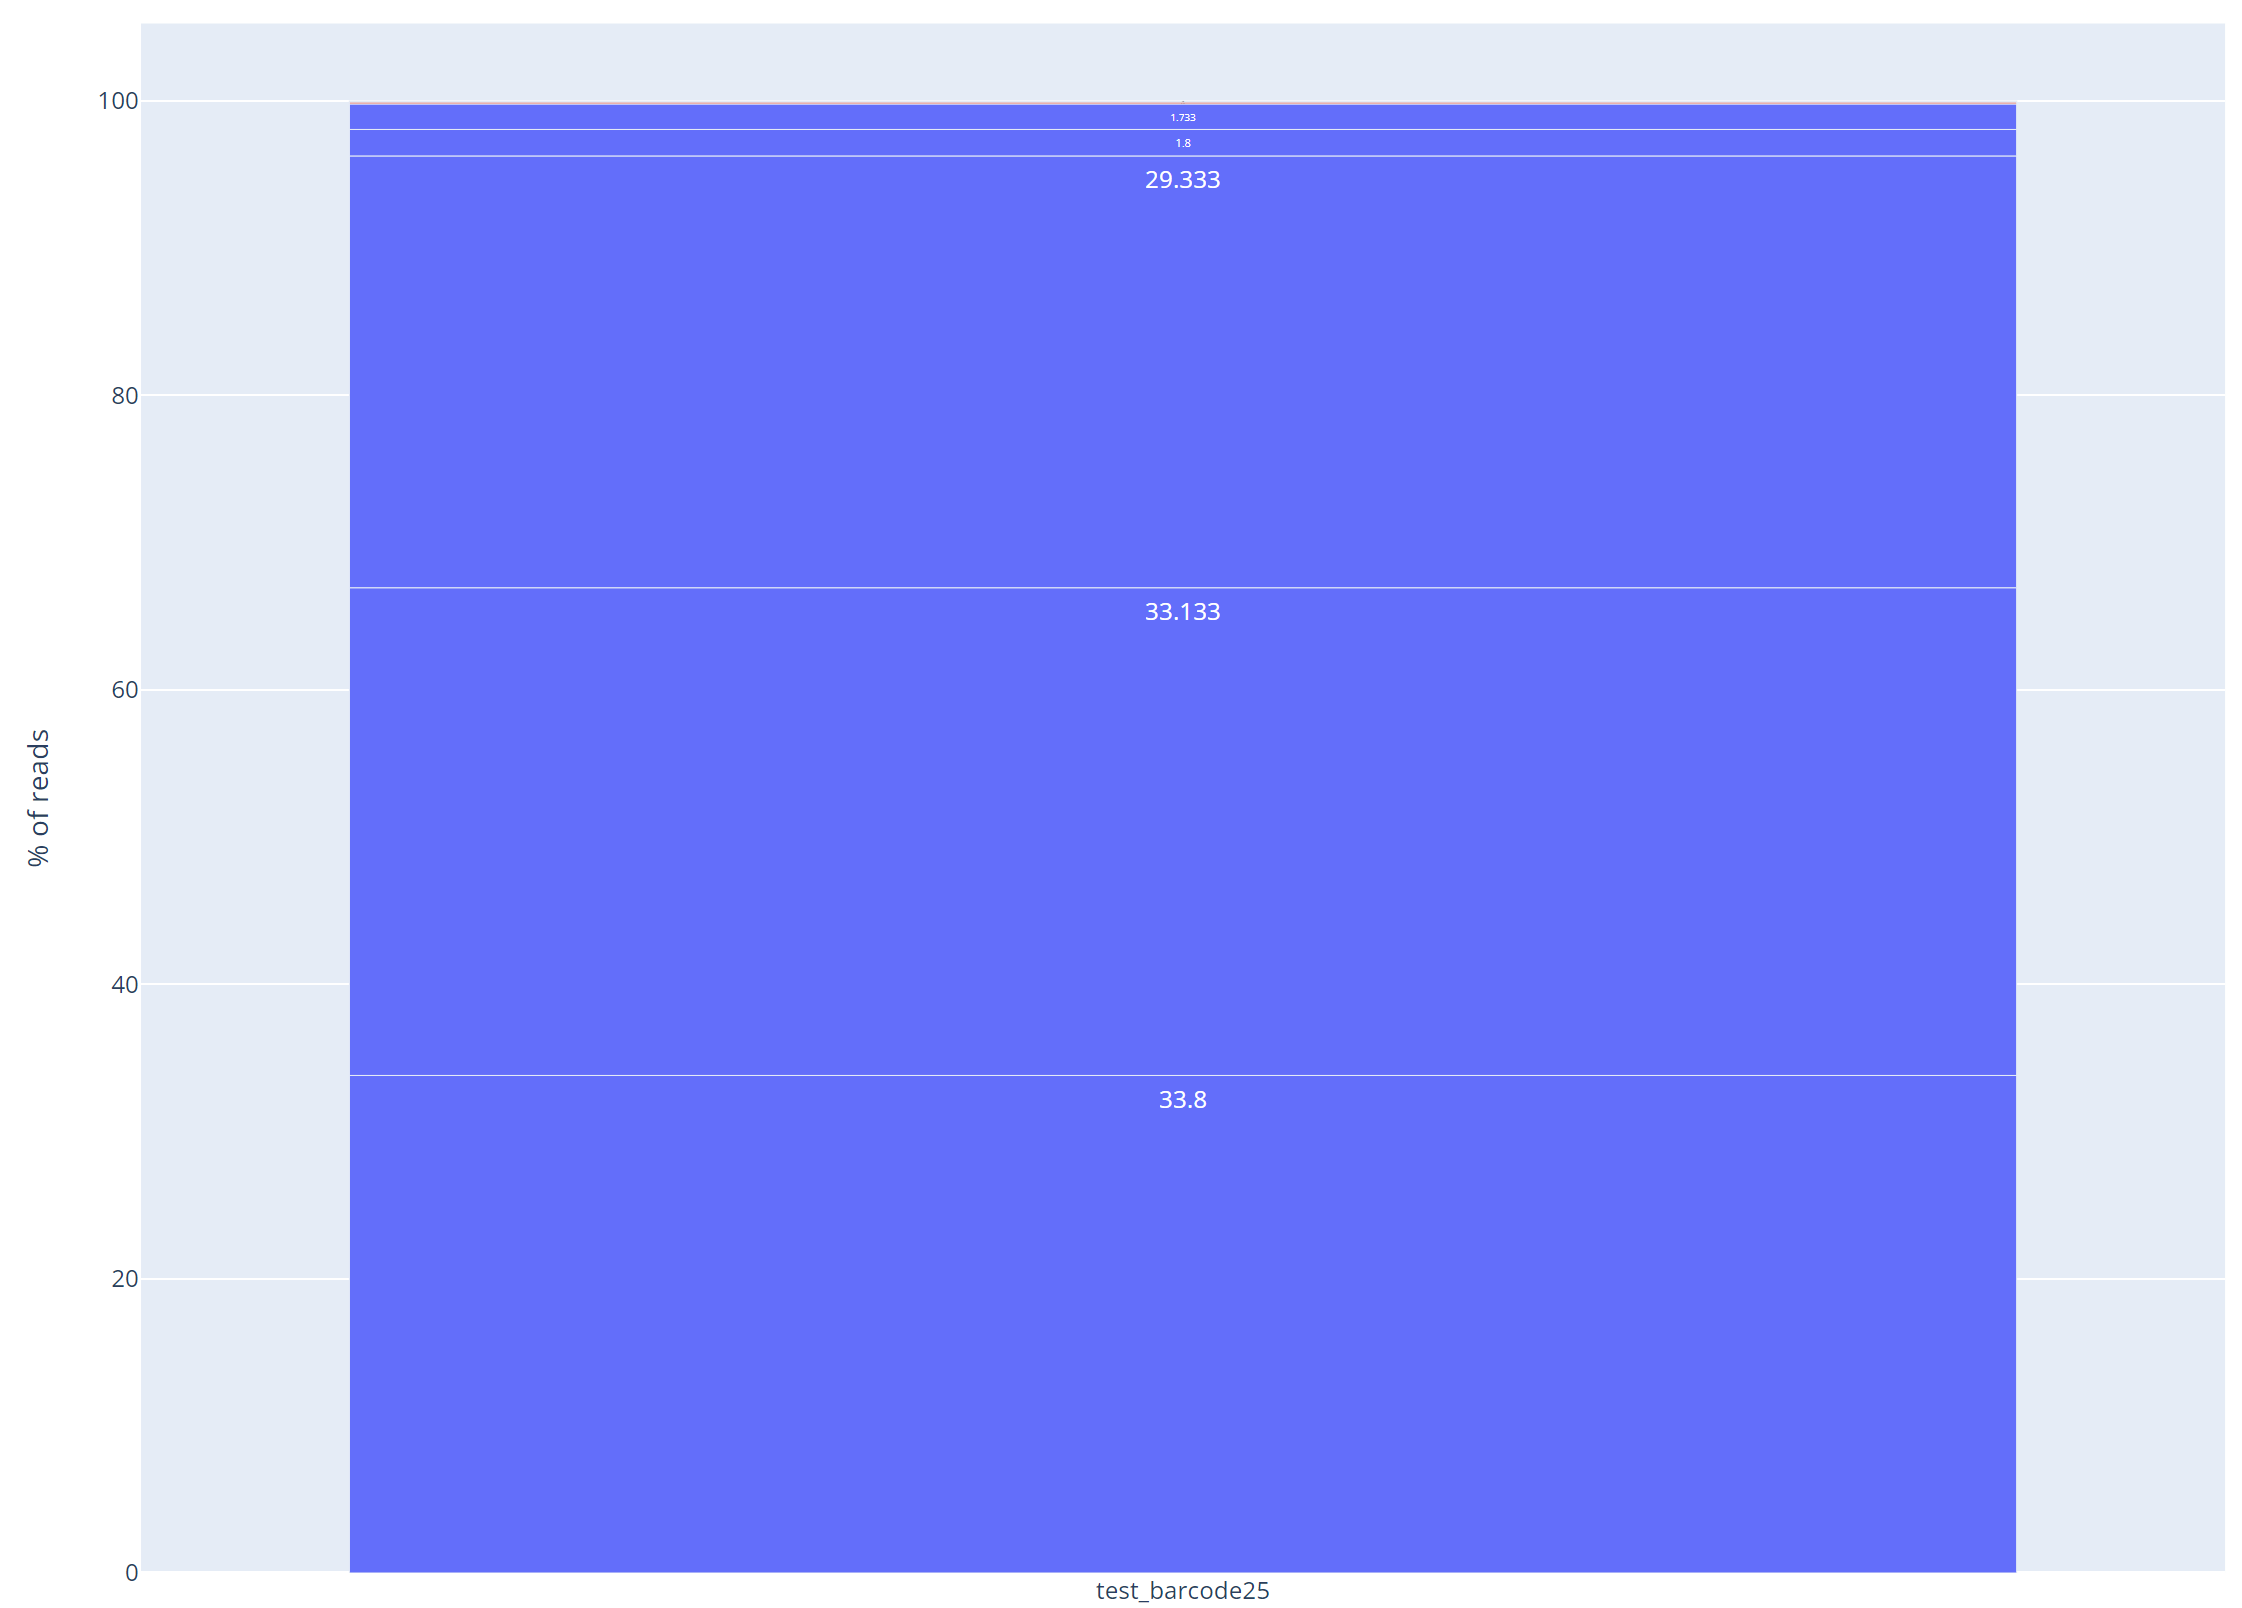

In [91]:
%%bash
rm -rf DAJINResults/single-ayabetask1
rm -rf DAJINResults/.tempdir/single-ayabetask1

pip install -qe .

time DAJIN2 \
    --name single-ayabetask1 \
    --sample examples/flox-cables2/AyabeTask1/barcode31.fq.gz \
    --control examples/flox-cables2/AyabeTask1/barcode42.fq.gz \
    --allele examples/flox-cables2/AyabeTask1/design_cables2.fa \
    --genome mm10 \
    --threads 10

examples/flox-cables2/AyabeTask1/barcode42.fq.gz is now processing...
2023-05-17 12:03:42: Preprocess barcode42...
2023-05-17 12:03:42: Mapping barcode42...
2023-05-17 12:03:45: Call MIDSV barcode42...
examples/flox-cables2/AyabeTask1/barcode42.fq.gz is finished!
examples/flox-cables2/AyabeTask1/barcode31.fq.gz is now processing...
2023-05-17 12:03:50: Preprocess barcode31...
2023-05-17 12:04:04: Classify barcode31...
2023-05-17 12:04:05: Clustering barcode31...
2023-05-17 12:04:09: Consensus calling barcode31......
examples/flox-cables2/AyabeTask1/barcode31.fq.gz is finished...


Finished! Open DAJINResults/single-ayabetask1 to see the report.

real	0m39.415s
user	0m25.453s
sys	0m0.952s


- Floxはホモポリマーの欠失が十分に補正されていないようです

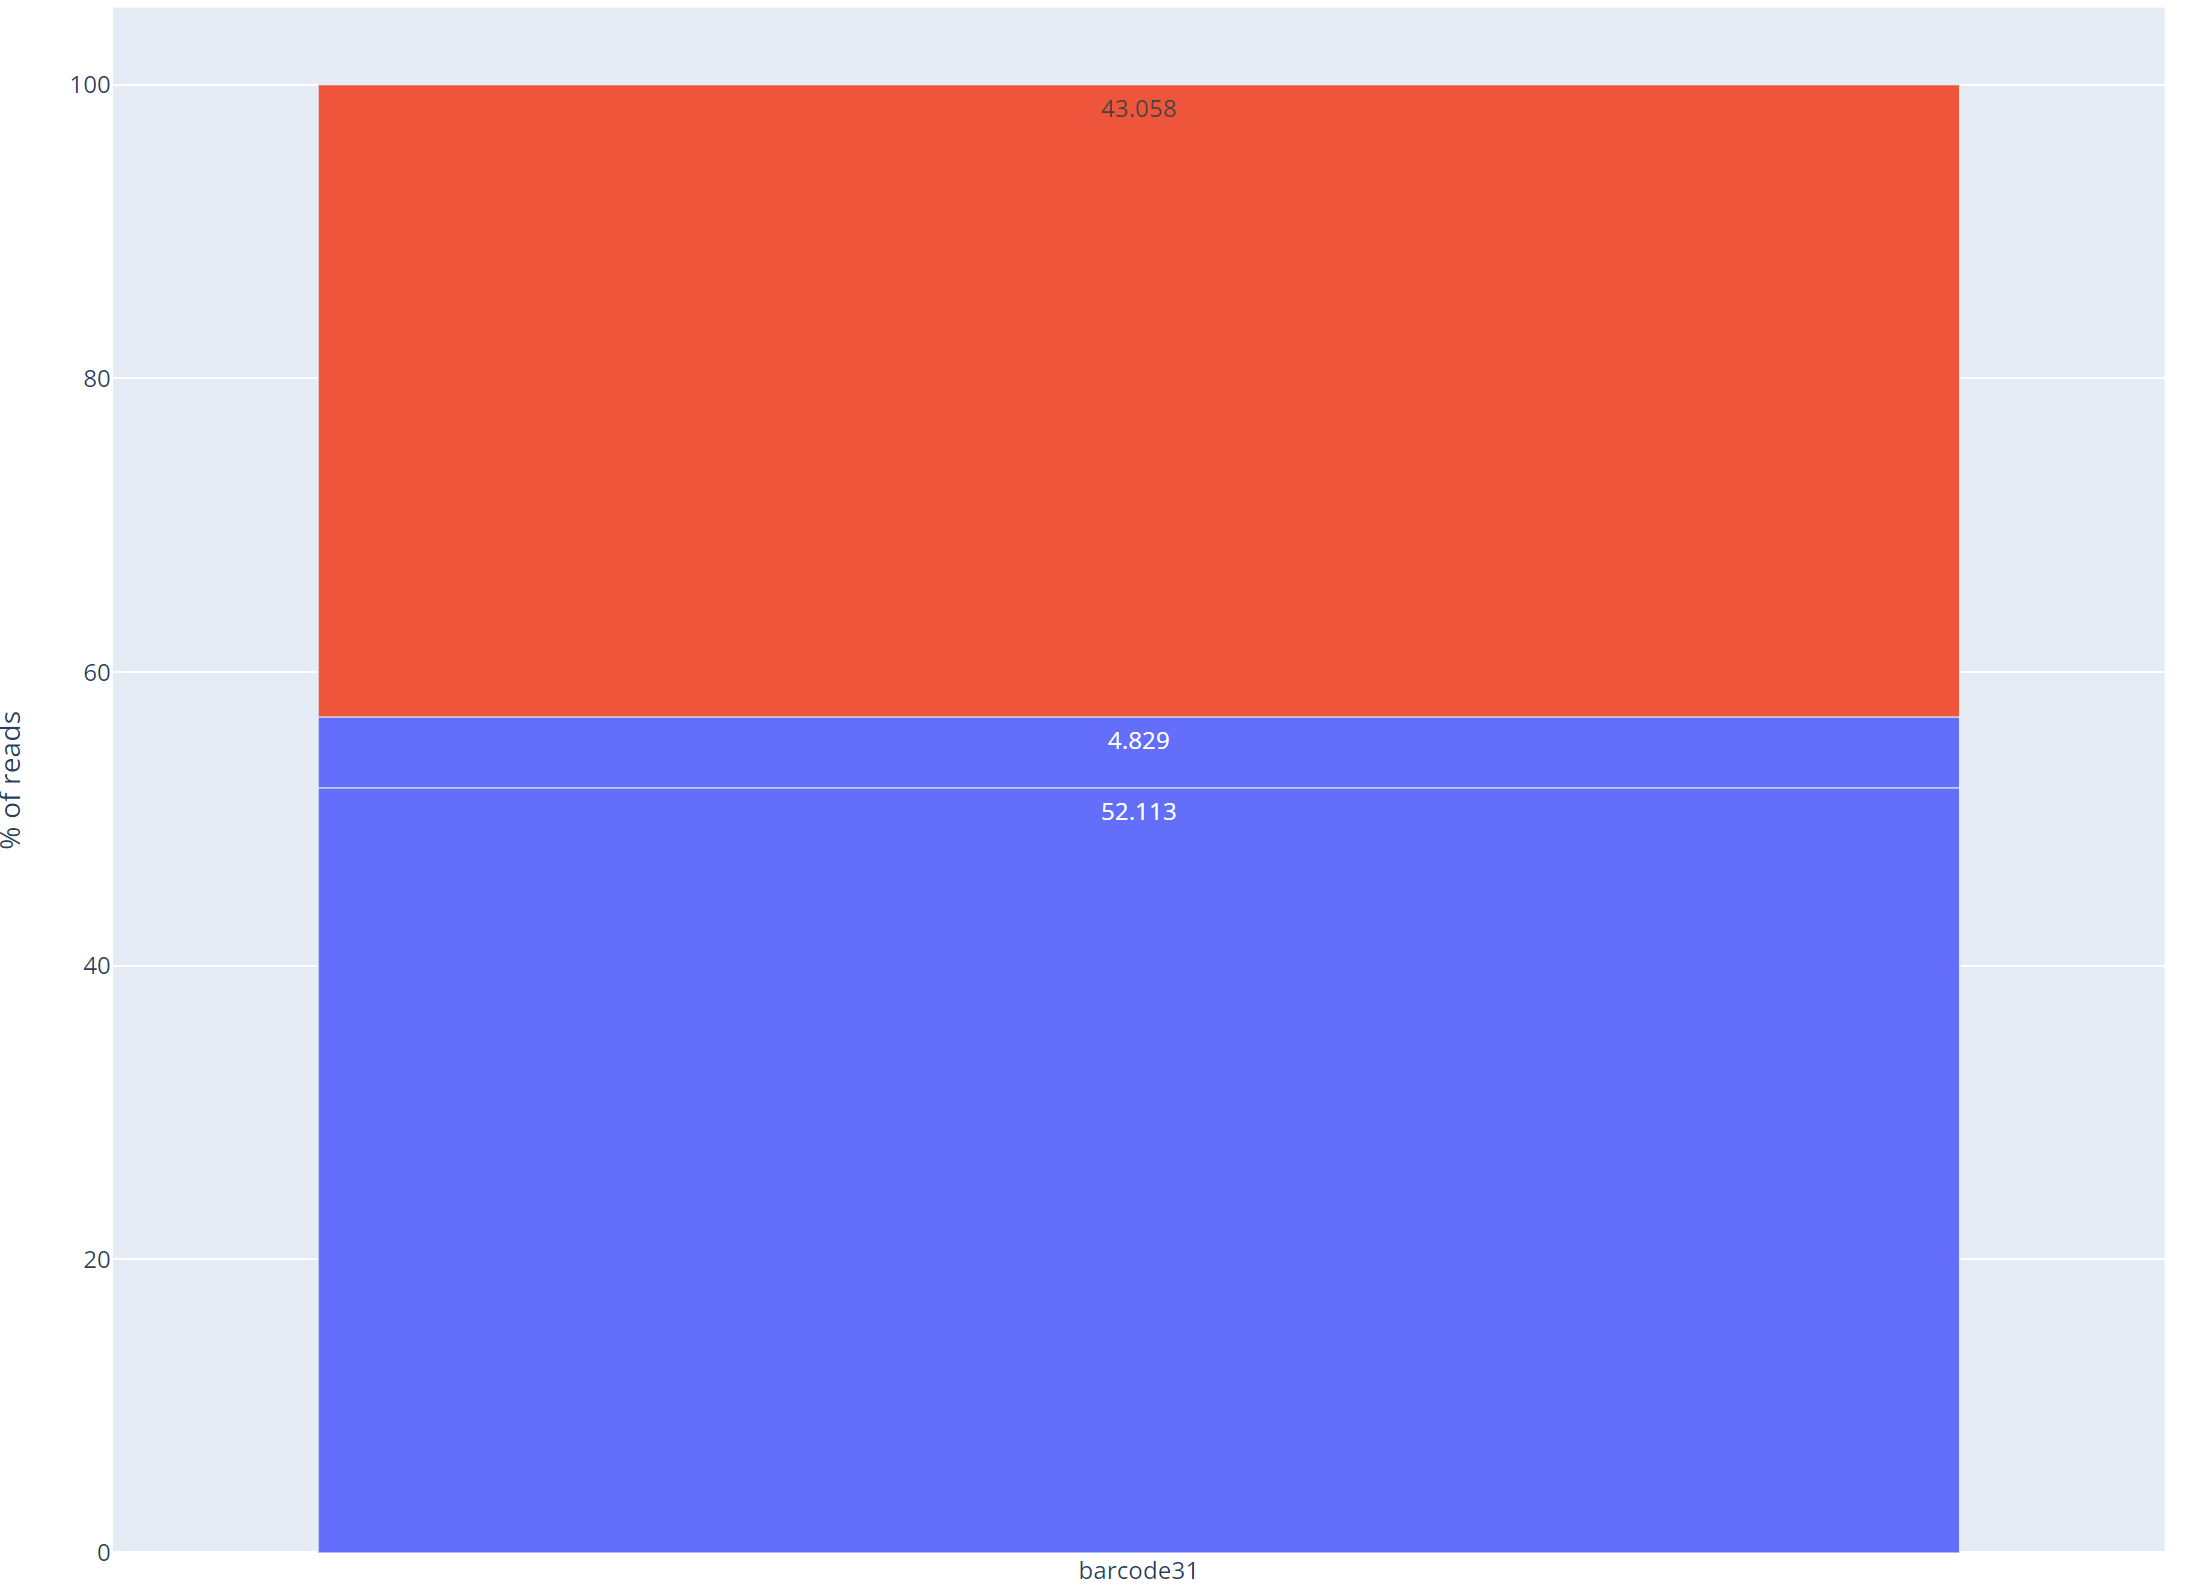

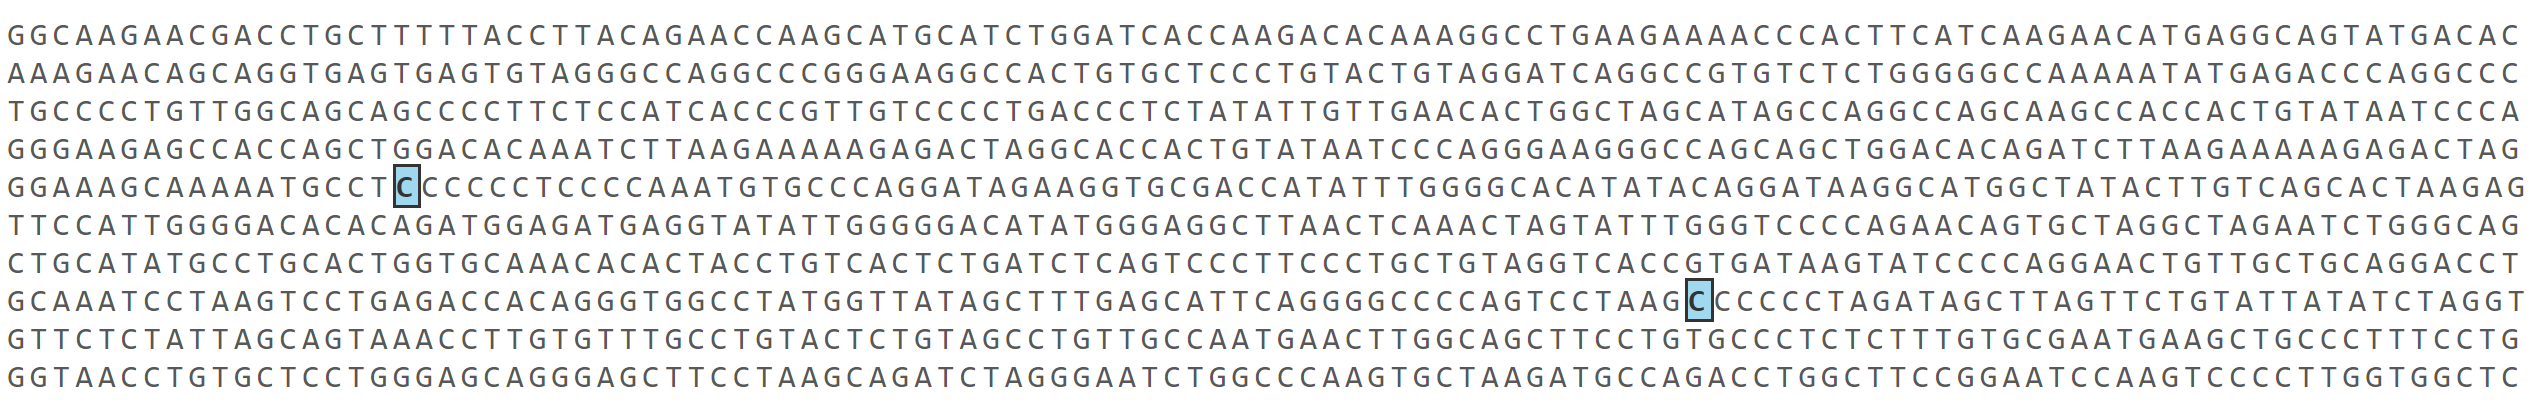

# 👉👉👉 いまここ 👈👈👈

# 👌👌👌 まとめ 👌👌👌


- `correct_sequence_error`がなくてもなんとなくうまく行きそうです
    - メモリがどれだけ逼迫するのか
    - Floxでホモポリマーの補正がなかったこと
- この2点が気になります
- ホモポリマーの補正については、`consensus`のステップでmutation_lociを再度考慮するようにコードを改めます

# 次に取り組むこと

- メモリを節約します
    - ✅ `calc_midsv`
    - ✅ `extract_mutation_loci`
    - ⬜ `correct_sequence_error`
    - ⬜ `classify`
    - ⬜ `clustaring`
    - ⬜ `consensus`
    - ⬜ `report`

### Lists

+ GUIの見栄え
+ igv.jsの起動
+ VCFによる長鎖挿入・欠失情報の付与
+ Figの作成
+ ⬜ Insertionのなかにある変異を同定する手法を考案する
+ ⬜ Ayabe-taks1のright_loxpがいまいちな理由を考察する
+ ✅ 断端リードの扱いをどうするべきか
+ ✅ `SV`の判定をconsensus callのあとにする
+ ✅ Tyrの動作確認
+ ✅ ayabe-task1のleft/right-loxpの検出
+ ✅ mutation_lociをpreprocessで使用したものに変更する
> + ⬜ `preprocess.correct_sequence_error.replace_atmark`のコードがわかりにくい
    + テストを用意してリファクタリングする